# Disease similarity - HPO and gene terms that drive the similarity

In [ ]:
import pandas as pd
import pickle
import numpy as np
from numpy.linalg import norm

# File paths
gene_embeddings_path = '/home/abamini/PhenoGnet/Code/wandb/offline-run-20250519_154930-xd0z2gdb/files/gene_embedding.pkl'
hpo_embeddings_path  = '/home/abamini/PhenoGnet/Code/wandb/offline-run-20250519_154930-xd0z2gdb/files/hpo_embedding.pkl'
sim_combined_path    = '/home/abamini/PhenoGnet/plots/similarity_scores_combined_run.csv'
dis2gene_path        = '/home/abamini/PhenoGnet/data/processed/dis2g.txt'
hpo2dis_path         = '/home/abamini/PhenoGnet/data/processed/hpo2dis.txt'
gene2id_path         = '/home/abamini/PhenoGnet/data/processed/gene2id.txt'

# Load similarity scores
sim_combined = pd.read_csv(sim_combined_path)
# Cast disease IDs to int
sim_combined['disease1'] = sim_combined['disease1'].astype(int)
sim_combined['disease2'] = sim_combined['disease2'].astype(int)

# Task 1: Top 5 disease pairs
top5 = sim_combined.sort_values(by="similarity", ascending=False).head(5)
print("Top 5 disease pairs with highest similarity:")
for _, row in top5.iterrows():
    print(f"- {row['disease1']} ↔ {row['disease2']}: {row['similarity']:.4f}")

# Task 2: Load embeddings and ensure NumPy arrays
with open(gene_embeddings_path, 'rb') as f:
    gene_embeddings = np.asarray(pickle.load(f))
with open(hpo_embeddings_path, 'rb') as f:
    hpo_embeddings = np.asarray(pickle.load(f))

print(f"\n# gene embeddings: {gene_embeddings.shape}")
print(f"# HPO embeddings:  {hpo_embeddings.shape}\n")

# Build disease→genes and disease→HPOs maps
d2g = {}
with open(dis2gene_path) as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) >= 2:
            did = int(parts[0])
            for g in parts[1].split(','):
                if g:
                    d2g.setdefault(did, []).append(int(g))
print()
d2h = {}
with open(hpo2dis_path) as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) >= 2:
            hpo_id = int(parts[0])
            for dis in parts[1].split(','):
                if dis:
                    did = int(dis)
                    d2h.setdefault(did, []).append(hpo_id)

# Task 3: Top 100 disease pairs
top100 = sim_combined.sort_values(by="similarity", ascending=False).head(100)
print("\nPer-pair overlaps for top 100 disease pairs:")

# Task 4: Overlap computation across top 100 pairs
total_overlap_genes = 0
total_union_genes = 0
total_overlap_hpo = 0
total_union_hpo = 0

for _, row in top100.iterrows():
    d1, d2 = int(row['disease1']), int(row['disease2'])
    # Genes
    genes1 = set(d2g.get(d1, []))
    genes2 = set(d2g.get(d2, []))
    overlap_genes = genes1 & genes2
    union_genes = genes1 | genes2
    num_overlap_genes = len(overlap_genes)
    num_union_genes = len(union_genes)
    perc_pair_genes = (num_overlap_genes / num_union_genes * 100) if num_union_genes > 0 else 0.0

    # HPO terms
    hpos1 = set(d2h.get(d1, []))
    hpos2 = set(d2h.get(d2, []))
    overlap_hpo = hpos1 & hpos2
    union_hpo = hpos1 | hpos2
    num_overlap_hpo = len(overlap_hpo)
    num_union_hpo = len(union_hpo)
    perc_pair_hpo = (num_overlap_hpo / num_union_hpo * 100) if num_union_hpo > 0 else 0.0



    # Accumulate totals
    total_overlap_genes += num_overlap_genes
    total_union_genes += num_union_genes
    total_overlap_hpo += num_overlap_hpo
    total_union_hpo += num_union_hpo

# Compute overall percentages
perc_genes = (total_overlap_genes / total_union_genes * 100) if total_union_genes > 0 else 0.0
perc_hpo   = (total_overlap_hpo   / total_union_hpo   * 100) if total_union_hpo   > 0 else 0.0

print(f"Overall gene overlap across top 100 pairs: {perc_genes:.2f}%")
print(f"Overall HPO overlap across top 100 pairs:  {perc_hpo:.2f}%")


Top 5 disease pairs with highest similarity:
- 1787.0 ↔ 1787.0: 1.0000
- 8581.0 ↔ 2729.0: 0.9998
- 19867.0 ↔ 11542.0: 0.9986
- 8581.0 ↔ 9374.0: 0.9983
- 25929.0 ↔ 6034.0: 0.9979

# gene embeddings: (18459, 32)
# HPO embeddings:  (19034, 32)


Per-pair overlaps for top 100 disease pairs:
Overall gene overlap across top 100 pairs: 11.41%
Overall HPO overlap across top 100 pairs:  7.19%


Disease_1: 8581-> C0005586 -> Bipolar Disorder {HP:0007302}

Disease_2: 2729 -> C0036341 -> Schizophrenia {HP:0100753}

# Top 100 vs Random disease similarity distribution after after removing overlaps

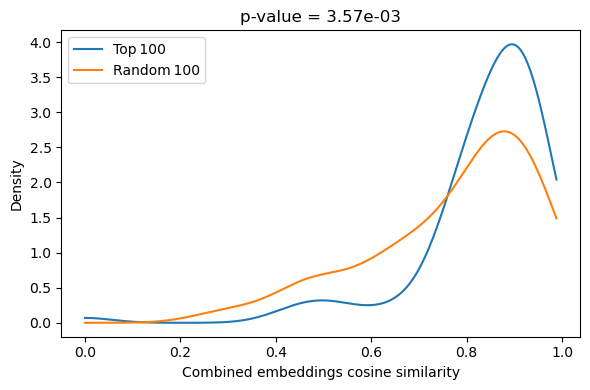

Mean (top 100)    = 0.8384
Mean (random 100) = 0.7720
Welch’s t-test: t = 2.950, p = 3.568e-03


In [3]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.stats import gaussian_kde, ttest_ind

# Paths
gene_embeddings_path = '/home/abamini/PhenoGnet/Code/wandb/offline-run-20250519_154930-xd0z2gdb/files/gene_embedding.pkl'
hpo_embeddings_path  = '/home/abamini/PhenoGnet/Code/wandb/offline-run-20250519_154930-xd0z2gdb/files/hpo_embedding.pkl'
sim_csv_path         = '/home/abamini/PhenoGnet/plots/similarity_scores_combined_run.csv'
dis2gene_path        = '/home/abamini/PhenoGnet/data/processed/dis2g.txt'
dis2hpo_path         = '/home/abamini/PhenoGnet/data/processed/hpo2dis.txt'

# Load embeddings
with open(gene_embeddings_path, 'rb') as f:
    gene_emb = np.asarray(pickle.load(f))
with open(hpo_embeddings_path, 'rb') as f:
    hpo_emb = np.asarray(pickle.load(f))

# Build disease→entity maps 
d2g = {}
with open(dis2gene_path) as f:
    for line in f:
        did, genes = line.strip().split(None, 1)
        d2g[int(did)] = [int(g) for g in genes.split(',') if g]

d2hpo = {}
with open(dis2hpo_path) as f:
    for line in f:
        terms, did = line.strip().split(None, 1)
        d2hpo[int(did)] = [int(t) for t in terms.split(',') if t]

# 1) Load CSV, pick top 100 and random 100
df = pd.read_csv(sim_csv_path)
df[['disease1','disease2']] = df[['disease1','disease2']].astype(int)
top100    = df.nlargest(100, 'similarity')
random100 = df.sample(100, random_state=42)

# Cosine helper & max‐nonoverlap function 
def cosine(u, v):
    return np.dot(u, v) / (norm(u)*norm(v) + 1e-8)

def compute_max_sims(pairs, emb, mapping):  # To drop any gene/HPO that’s in both diseases:
    out = []
    for _, r in pairs.iterrows():
        s1, s2 = set(mapping.get(r.disease1, [])), set(mapping.get(r.disease2, []))
        only1, only2 = s1 - s2, s2 - s1
        m = 0.0
        for i in only1:
            vi = emb[i]
            for j in only2:
                sim = cosine(vi, emb[j])
                if sim > m:
                    m = sim
        out.append(m)
    return np.array(out)

# 2) Compute gene/HPO sims
gene_top  = compute_max_sims(top100,    gene_emb, d2g)
gene_rand = compute_max_sims(random100, gene_emb, d2g)
hpo_top   = compute_max_sims(top100,    hpo_emb,  d2hpo)
hpo_rand  = compute_max_sims(random100, hpo_emb,  d2hpo)

# 3) Weighted combination 
gamma = 0.5   # 50% HPO, 50% gene
combined_top  = gamma * hpo_top  + (1-gamma) * gene_top
combined_rand = gamma * hpo_rand + (1-gamma) * gene_rand

# 4) Statistics — compute before plotting so we can use p-value in the title
tstat, p = ttest_ind(combined_top, combined_rand, equal_var=False)

# 5) Plot only the combined distribution 
xs = np.linspace(
    min(combined_top.min(), combined_rand.min()),
    max(combined_top.max(), combined_rand.max()),
    200
)
kde_top  = gaussian_kde(combined_top)
kde_rand = gaussian_kde(combined_rand)

plt.figure(figsize=(6, 4))
plt.plot(xs, kde_top(xs),  label='Top 100')
plt.plot(xs, kde_rand(xs), label='Random 100')
plt.xlabel('Combined embeddings cosine similarity')
plt.ylabel('Density')
plt.title(f'p-value = {p:.2e}')
plt.legend()
plt.tight_layout()
plt.show()

# 6) Print statistics
print(f"Mean (top 100)    = {combined_top.mean():.4f}")
print(f"Mean (random 100) = {combined_rand.mean():.4f}")
print(f"Welch’s t-test: t = {tstat:.3f}, p = {p:.3e}")
